In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve, accuracy_score, f1_score

In [2]:
# Load the finalized dataset
df = pd.read_csv("../Datasets/pokedex_final.csv")

# Combine type1 and type2 into a list
df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t) and t != ''])

# Encode the types with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['type_list'])

# Tokenize the enhanced_info column
text_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df['enhanced_info'])

sequences = text_tokenizer.texts_to_sequences(df['enhanced_info'])
X_text = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

# Normalize numeric features
stats_cols = ['hp', 'attack', 'defense', 's_attack', 'speed', 'height', 'weight']
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[stats_cols])

In [ ]:
# Combine
combined = Concatenate()([text_lstm, input_stats])
hidden = Dense(256, activation='relu')(combined)

# >>> Add a dropout layer
hidden = Dropout(0.5)(hidden)

output = Dense(len(mlb.classes_), activation='sigmoid')(hidden)


model = Model(inputs=[input_text, input_stats], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Calculate class weights based on label frequency
class_totals = y.sum(axis=0)
class_weights = y.shape[0] / (len(mlb.classes_) * class_totals)

# Convert class weights to numpy array
class_weights = np.array(class_weights)

# Print class weights to check
print(dict(zip(mlb.classes_, class_weights)))

# Train-Test Split
X_train_text, X_test_text, X_train_stats, X_test_stats, y_train, y_test = train_test_split(
    X_text, X_stats, y, test_size=0.2, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Now fit the model with early stopping
history = model.fit(
    [X_train_text, X_train_stats],
    y_train,
    validation_data=([X_test_text, X_test_stats], y_test),
    epochs=100,
    batch_size=32,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stop]  # <<< ADD this!
)

# Updated thresholds based on your new dictionary
best_thresholds = np.array([
    0.0010278029,  # bug
    8.1377993e-07, # dark
    0.46437493,    # dragon
    0.0019469165,  # electric
    3.991257e-05,  # fairy
    0.00040400133, # fighting
    0.90612555,    # fire
    0.72205424,    # flying
    1.6753791e-05, # ghost
    0.0010286915,  # grass
    0.0018877859,  # ground
    0.0066630044,  # ice
    0.00015980248, # normal
    0.005488699,   # poison
    0.21398078,    # psychic
    0.0042396197,  # rock
    0.0007712165,  # steel
    0.08663599     # water
])


# Adjust the threshold for specific types based on their frequencies
fairy_idx = list(mlb.classes_).index('fairy')
best_thresholds[fairy_idx] = 0.5  # Lower threshold for fairy (to make it easier to predict)

ice_idx = list(mlb.classes_).index('ice')
best_thresholds[ice_idx] = 0.3  # Lower threshold for ice

ghost_idx = list(mlb.classes_).index('ghost')
best_thresholds[ghost_idx] = 0.3  # Lower threshold for ghost

steel_idx = list(mlb.classes_).index('steel')
best_thresholds[steel_idx] = 0.4  # Lower threshold for steel

dragon_idx = list(mlb.classes_).index('dragon')
best_thresholds[dragon_idx] = 0.4  # Lower threshold for dragon

dark_idx = list(mlb.classes_).index('dark')
best_thresholds[dark_idx] = 0.4  # Lower threshold for dark

electric_idx = list(mlb.classes_).index('electric')
best_thresholds[electric_idx] = 0.4  # Lower threshold for electric

# Save model and label binarizer
model.save("rnn_stats_pokemon_model.keras")
pd.DataFrame(mlb.classes_, columns=['Type']).to_csv("type_classes.csv", index=False)

c:\Users\arvee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 300, 64)   │    320,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    197,632 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 263)       │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     67,584 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 18)        │      4,626 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 589,842 (2.25 MB)

 Trainable params: 589,842 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

{'bug': 0.6189613526570048, 'dark': 0.8252818035426731, 'dragon': 0.8134920634920635, 'electric': 0.8252818035426731, 'fairy': 0.8897569444444444, 'fighting': 0.7800608828006088, 'fire': 0.7030178326474623, 'flying': 0.5224260958205912, 'ghost': 0.8760683760683761, 'grass': 0.4483814523184602, 'ground': 0.7592592592592593, 'ice': 1.1863425925925926, 'normal': 0.43469041560644617, 'poison': 0.6860776439089692, 'psychic': 0.5582788671023965, 'rock': 0.7695195195195195, 'steel': 0.8760683760683761, 'water': 0.36976911976911975}
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.0468 - loss: 0.3562 - val_accuracy: 0.0732 - val_loss: 0.2859
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.0833 - loss: 0.1958 - val_accuracy: 0.1073 - val_loss: 0.2790
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.0914 - loss: 0.1920 - val_accuracy: 0.1171 - val_loss: 0.2769
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.1328 - loss: 0

In [20]:
# Load model
model = tf.keras.models.load_model("rnn_stats_pokemon_model.keras")

# Predict probabilities
y_pred_probs = model.predict([X_test_text, X_test_stats])

# >>>>> CHANGE: Find best threshold for each class individually
best_thresholds = []

for i in range(y.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1)]
    best_thresholds.append(best_threshold)

best_thresholds = np.array(best_thresholds)

# Apply best thresholds
y_pred = (y_pred_probs > best_thresholds).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


c:\Users\arvee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


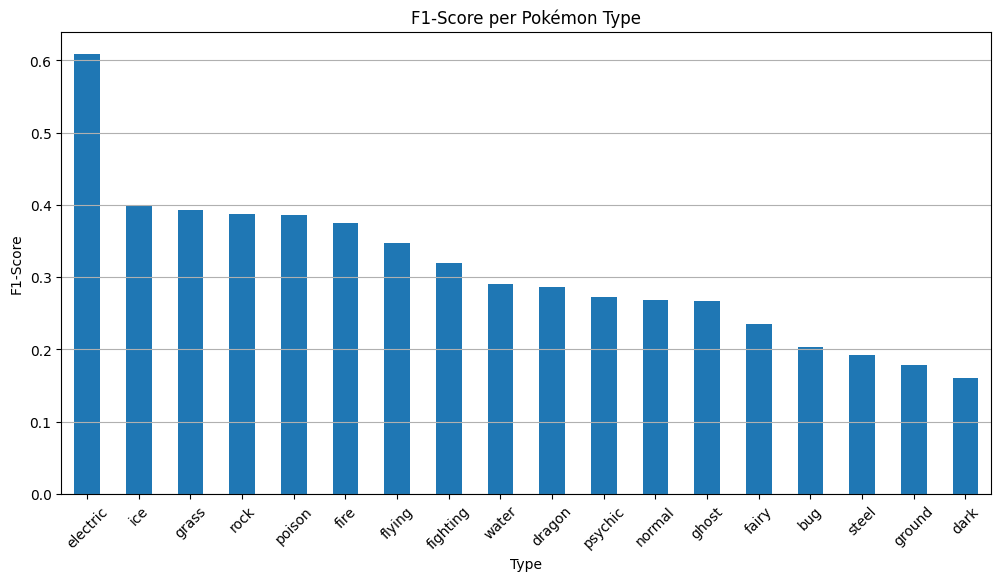

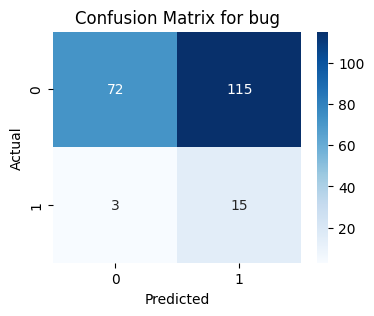

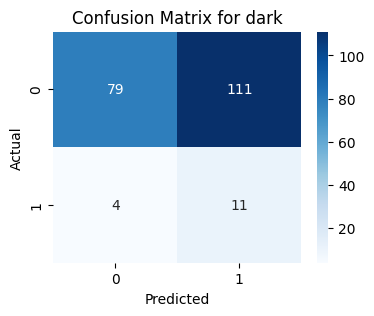

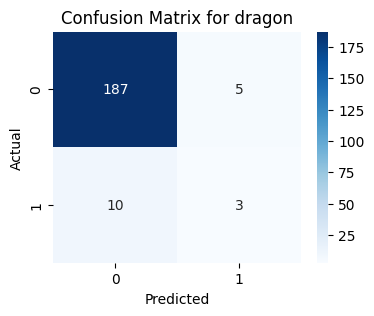

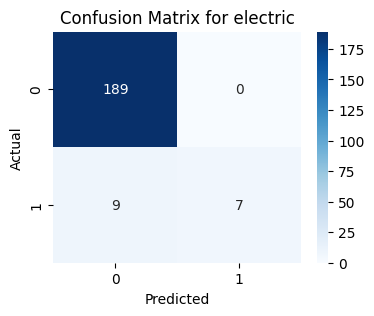

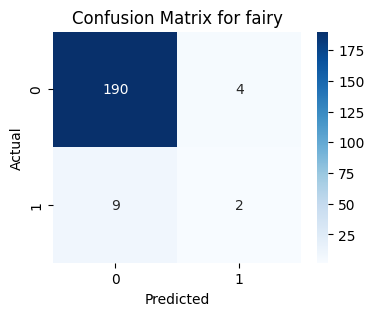

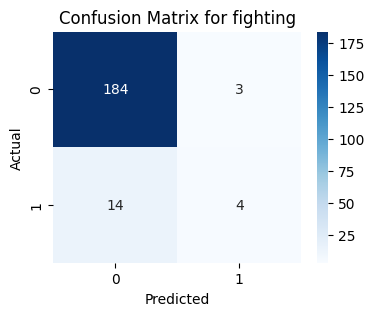

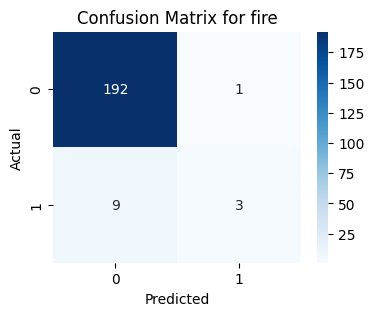

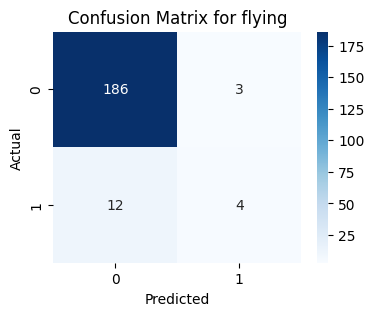

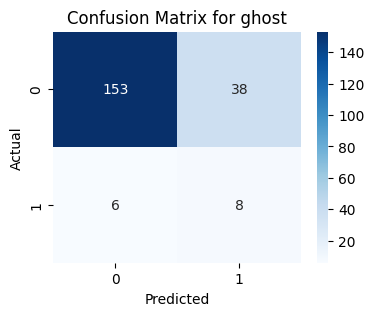

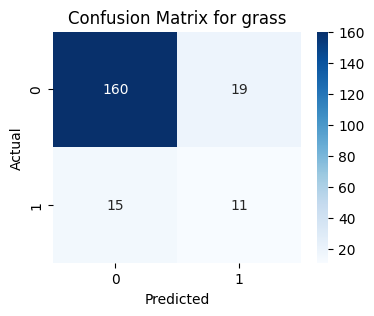

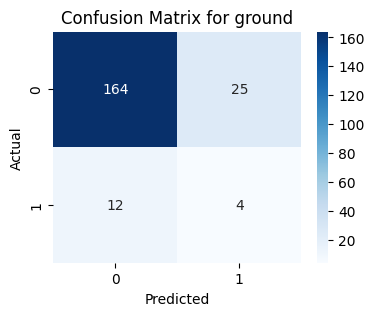

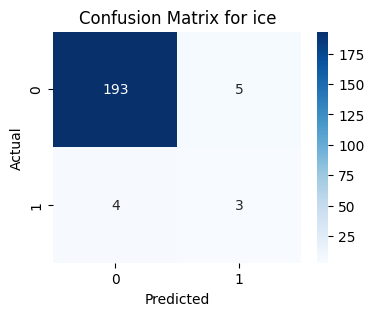

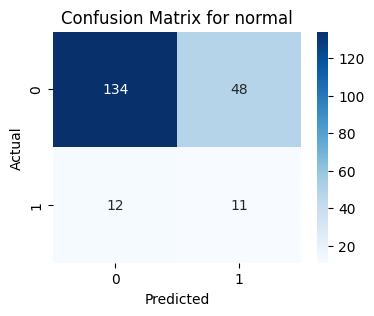

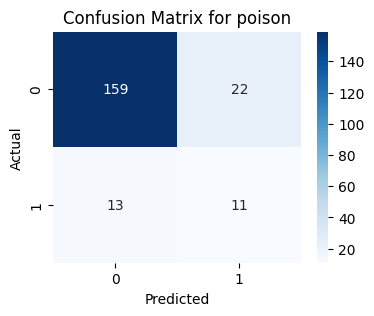

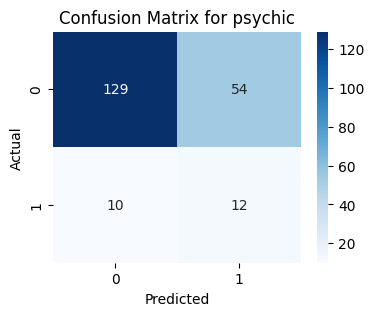

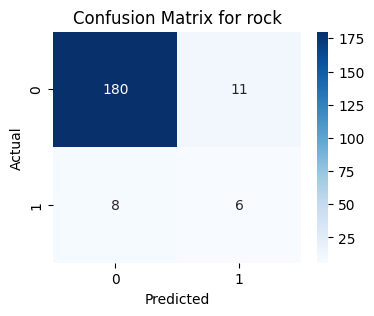

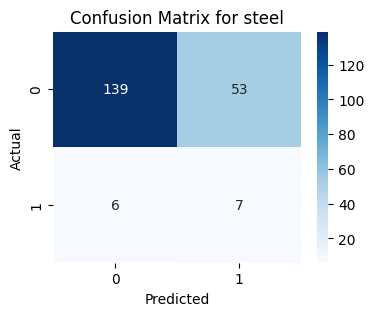

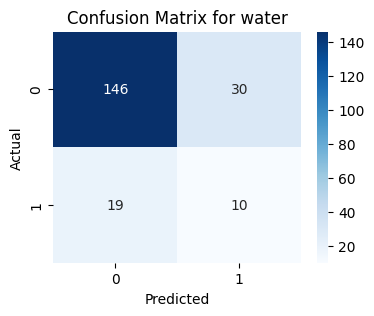

In [21]:
# Classification report
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)

# Convert report to DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Display F1 scores per type
f1_scores = report_df.loc[mlb.classes_, 'f1-score']
plt.figure(figsize=(12,6))
f1_scores.sort_values(ascending=False).plot(kind='bar')
plt.title('F1-Score per Pokémon Type')
plt.ylabel('F1-Score')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Confusion matrices
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

for idx, type_name in enumerate(mlb.classes_[:18]):
    cm = conf_matrices[idx]
    plt.figure(figsize=(4,3))
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {type_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [9]:
y_pred_probs = model.predict([X_test_text, X_test_stats])
print("Max prob:", np.max(y_pred_probs))
print("Mean prob:", np.mean(y_pred_probs))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Max prob: 0.9999999
Mean prob: 0.050462484


In [10]:
import numpy as np

pred_counts = y_pred.sum(axis=0)
true_counts = y_test.sum(axis=0)

for cls, pred, true in zip(mlb.classes_, pred_counts, true_counts):
    print(f"{cls:10s} | predicted: {pred:3d} | actual: {true:3d}")


bug        | predicted:  59 | actual:  18
dark       | predicted: 120 | actual:  15
dragon     | predicted:  12 | actual:  13
electric   | predicted:  29 | actual:  16
fairy      | predicted:  66 | actual:  11
fighting   | predicted:  51 | actual:  18
fire       | predicted:   5 | actual:  12
flying     | predicted:  15 | actual:  16
ghost      | predicted:  34 | actual:  14
grass      | predicted:  40 | actual:  26
ground     | predicted:  27 | actual:  16
ice        | predicted:  12 | actual:   7
normal     | predicted:  66 | actual:  23
poison     | predicted:  20 | actual:  24
psychic    | predicted:  23 | actual:  22
rock       | predicted:  13 | actual:  14
steel      | predicted:  30 | actual:  13
water      | predicted:  34 | actual:  29


In [11]:
import pandas as pd

df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t)])

all_types = pd.Series([t for sublist in df['type_list'] for t in sublist])
print(all_types.value_counts())


water       154
normal      131
grass       127
flying      109
psychic     102
bug          92
poison       83
fire         81
ground       75
rock         74
fighting     73
dragon       70
dark         69
electric     69
steel        65
ghost        65
fairy        64
ice          48
dtype: int64


In [12]:
print(dict(zip(mlb.classes_, best_thresholds)))

{'bug': 0.0010278029, 'dark': 8.1377993e-07, 'dragon': 0.46437493, 'electric': 0.0019469165, 'fairy': 3.991257e-05, 'fighting': 0.00040400133, 'fire': 0.90612555, 'flying': 0.72205424, 'ghost': 1.6753791e-05, 'grass': 0.0010286915, 'ground': 0.0018877859, 'ice': 0.0066630044, 'normal': 0.00015980248, 'poison': 0.005488699, 'psychic': 0.21398078, 'rock': 0.0042396197, 'steel': 0.0007712165, 'water': 0.08663599}


In [14]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test (true labels) and y_pred (predicted labels) are already defined
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)

# Convert the classification report into a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Extract the F1 scores for each type (both per-class and averages)
f1_scores_per_type = report_df['f1-score']

# Print F1 scores for each class
print("F1 Scores per Pokémon Type:")
print(f1_scores_per_type)

# Print the average F1 scores
print("\nAverage F1 Scores:")
print(f"Macro Average F1: {report_df.loc['macro avg', 'f1-score']:.4f}")
print(f"Weighted Average F1: {report_df.loc['weighted avg', 'f1-score']:.4f}")

# For each test sample, find the indices of the 2 highest probabilities
top2_preds = np.argsort(y_pred_probs, axis=1)[:, -2:]

# Count correct if any of the true labels are in top-2 predictions
correct_top2 = 0
for true_labels, pred_labels in zip(y_test, top2_preds):
    true_types = np.where(true_labels == 1)[0]  # indices of true labels
    if any(t in pred_labels for t in true_types):
        correct_top2 += 1

top2_accuracy = correct_top2 / len(y_test)
print(f"\nTop-2 Accuracy: {top2_accuracy:.4f}")


F1 Scores per Pokémon Type:
bug             0.233766
dark            0.148148
dragon          0.240000
electric        0.533333
fairy           0.103896
fighting        0.202899
fire            0.470588
flying          0.322581
ghost           0.291667
grass           0.484848
ground          0.232558
ice             0.421053
normal          0.224719
poison          0.409091
psychic         0.266667
rock            0.370370
steel           0.232558
water           0.317460
micro avg       0.272066
macro avg       0.305900
weighted avg    0.310464
samples avg     0.262578
Name: f1-score, dtype: float64

Average F1 Scores:
Macro Average F1: 0.3059
Weighted Average F1: 0.3105

Top-2 Accuracy: 0.4146
